# Discourse structure and agreement attraction 

Implements a basic running of the agreement experiments. 

Created by Forrest Davis
May 2024

## Install and import packages, download code, and download data


In [1]:
useLocal = True
if not useLocal:
    !pip install transformers tiktoken openai dill

In [2]:
import transformers
import torch
import pandas as pd
import sys
import glob

/Users/forrestdavis/miniconda3/envs/nlp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#Clone the evaluation repo
if not useLocal: 
    !git clone https://github.com/forrestdavis/PublicModelsAPI.git
    # Add to path  
    path = "/content/"
else:
    path = '/Users/forrestdavis/Projects/'
path2API = f"{path}PublicModelsAPI"
sys.path.append(path2API)

In [4]:
exp1 = pd.read_csv('../material/attraction_exp1.csv')
exp2 = pd.read_csv('../material/attraction_exp2.csv')
exp3 = pd.read_csv('../material/attraction_exp3.csv')

In [5]:
exp1.head(3)

,ItemNo,Clause,Distractor,Grammaticality,Condition,Question,Answer,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,w11,w12,w13
0,1,appos,plural,gram,e.appos.plural.gram,Was the waitress unhappy about all the noise?,yes,"The_waitress,",who,sat,near,"the_girls,",unsurprisingly,was,unhappy,about,all,the_noise.,NaN,NaN
1,1,appos,singular,gram,e.appos.singular.gram,Was the waitress unhappy about all the noise?,yes,"The_waitress,",who,sat,near,"the_girl,",unsurprisingly,was,unhappy,about,all,the_noise.,NaN,NaN
2,1,appos,plural,ungram,e.appos.plural.ungram,Was the waitress unhappy about all the noise?,yes,"The_waitress,",who,sat,near,"the_girls,",unsurprisingly,were,unhappy,about,all,the_noise.,NaN,NaN


In [6]:
exp2.head(3)

,ItemNo,Clause,Distractor,Grammaticality,Condition,w1,w2,w3,w4,w5,...,w11,w12,w13,w14,w15,w16,w17,w18,w19,w20
0,1,restr,plural,gram,e.restr.plural.gram,The,runners,who,the,driver,...,morning,always,wave,to,say,hi.,NaN,NaN,NaN,NaN
1,1,restr,singular,gram,e.restr.singular.gram,The,runner,who,the,driver,...,morning,always,waves,to,say,hi.,NaN,NaN,NaN,NaN
2,1,restr,plural,ungram,e.restr.plural.ungram,The,runners,who,the,driver,...,morning,always,wave,to,say,hi.,NaN,NaN,NaN,NaN


In [7]:
exp3.head(3)

,ItemNo,Clause,Distractor,Grammaticality,Condition,w1,w2,w3,w4,w5,...,w8,w9,w10,w11,w12,w13,w14,w15,w16,w17
0,1,restr,plural,gram,e.restr.plural.gram,Mike,chased,the,runners,who,...,sees,during,the,commute,every,morning.,NaN,NaN,NaN,NaN
1,1,restr,singular,gram,e.restr.singular.gram,Mike,chased,the,runner,who,...,sees,during,the,commute,every,morning.,NaN,NaN,NaN,NaN
2,1,restr,plural,ungram,e.restr.plural.ungram,Mike,chased,the,runners,who,...,see,during,the,commute,every,morning.,NaN,NaN,NaN,NaN


## Format data

Add column with the prefix form

In [8]:
# make NaN empty string
exp1 = exp1.fillna('')
exp2 = exp2.fillna('')
exp3 = exp3.fillna('')

# relevant columns stop at w7 for exp1
columns = [f'w{x}' for x in range(1, 8)]
words = exp1[columns]
sentences = [' '.join(x).strip().replace('_', ' ') for x in words.values]
exp1['sentence'] = sentences

# relevant columns stop at w6 for exp2 
columns = [f'w{x}' for x in range(1, 7)]
words = exp2[columns]
sentences = [' '.join(x).strip().replace('_', ' ') for x in words.values]
exp2['sentence'] = sentences

# relevant columns stop at w8 for exp3
columns = [f'w{x}' for x in range(1, 9)]
words = exp3[columns]
sentences = [' '.join(x).strip().replace('_', ' ') for x in words.values]
exp3['sentence'] = sentences

## Run Model

Load a pretrained model, run on sentences, gather surprisals for the target (the/their) and the dp (e.g., the customers).

In [11]:
model_names = ["gpt2", "gpt2-medium", "gpt2-large", "gpt2-xl", 
               "EleutherAI/gpt-neo-125m", "EleutherAI/gpt-neo-1.3B", "EleutherAI/gpt-neo-2.7B", 
               "microsoft/DialoGPT-small", "microsoft/DialoGPT-medium", "microsoft/DialoGPT-large", 
               "meta-llama/Meta-Llama-3-8B-Instruct", "meta-llama/Meta-Llama-3-8B", 
               "EleutherAI/gpt-j-6b",
               "microsoft/GODEL-v1_1-base-seq2seq", "microsoft/GODEL-v1_1-large-seq2seq", 
               "mistralai/Mistral-7B-v0.3", "mistralai/Mistral-7B-Instruct-v0.3",
              "meta-llama/Llama-2-7b-hf", "meta-llama/Llama-2-13b-hf", 
              "meta-llama/Llama-2-7b-chat-hf", "meta-llama/Llama-2-13b-chat-hf"]
model_strs = ["GPT2-small", 'GPT2-medium', 'GPT2-large', "GPT2-XL", 
              "GPT-Neo-125m", "GPT-Neo-1.3B", "GPT-Neo-2.7B", 
              "DialoGPT-small", "DialoGPT-medium", "DialoGPT-large", 
             "Llama-3-8B-Instruct", "Llama-3-8B", 
             "GPT-J-6B", 
             "GODEL-base", "GODEL-large", 
             "Mistral-7B-v0.3", "Mistral-7B-Instruct-v0.3", 
             "Llama-2-7B", "Llama-2-13B", 
             "Llama-2-7B-Chat", 'Llama-2-13B-Chat']
model_types = ['auto-causal']*13+['godel', 'godel']+['mistral', 'mistral'] + ['llama']*4

In [10]:
from src.models import models
# Run exp1
assert len(model_names) == len(model_types) == len(model_strs), "Mismatch in model, type, and string"

for model_name, model_str, model_type in zip(model_names, model_strs, model_types):

    if not ('Llama-2-' in model_name):
        continue

    if 'meta-llama/Llama-2-7b-hf' in model_name:
        continue

    if '13b' in model_name: 
        batchSize = 20
    else:
        bathcSize = 40

    print(f"Running {model_name}...")
    
    surp_exp1 = exp1.copy()
    model_config = {'models': {model_type: [model_name]}}

    model = models.load_models(model_config)[0]
    
    verb_surps = []
    sentences = exp1['sentence'].tolist()

    for batch_idx in range(0, len(sentences), batchSize):
        batch = sentences[batch_idx:batch_idx+batchSize]
        by_word_surprisal = model.get_aligned_words_surprisals(batch, include_punctuation=True)
        # Get the last word in each sentence in the batch
        for surps in by_word_surprisal:   
            verb_surps.append(surps[-1].surp)

    surp_exp1['model'] = model_str
    surp_exp1['modelname'] = model_name
    surp_exp1['surp'] = verb_surps
    outname = f"sub_results/exp1_{model_str}.tsv"
    print(f"Saving to {outname}...")
    surp_exp1.to_csv(outname, index=False, sep='\t')
    del model

Running meta-llama/Llama-2-13b-hf...


Running on mps
/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

RuntimeError: MPS backend out of memory (MPS allocated: 36.26 GB, other allocations: 384.00 KB, max allowed: 36.27 GB). Tried to allocate 270.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [ ]:
from src.models import models
# Run exp2
assert len(model_names) == len(model_types) == len(model_strs), "Mismatch in model, type, and string"

for model_name, model_str, model_type in zip(model_names, model_strs, model_types):

    if not ('mistralai' in model_name):#or 'Llama-2-' in model_name):
        continue
    
    print(f"Running {model_name}...")
    
    surp_exp2 = exp2.copy()
    model_config = {'models': {model_type: [model_name]}}

    model = models.load_models(model_config)[0]

    verb_surps = []
    sentences = exp2['sentence'].tolist()
    batchSize = 20

    for batch_idx in range(0, len(sentences), batchSize):
        batch = sentences[batch_idx:batch_idx+batchSize]
        by_word_surprisal = model.get_aligned_words_surprisals(batch, include_punctuation=True)
        # Get the last word in each sentence in the batch
        for surps in by_word_surprisal:   
            verb_surps.append(surps[-1].surp)

    surp_exp2['model'] = model_str
    surp_exp2['modelname'] = model_name
    surp_exp2['surp'] = verb_surps
    outname = f"sub_results/exp2_{model_str}.tsv"
    print(f"Saving to {outname}...")    
    surp_exp2.to_csv(outname, index=False, sep='\t')
    del model


In [ ]:
from src.models import models
# Run exp3
assert len(model_names) == len(model_types) == len(model_strs), "Mismatch in model, type, and string"

for model_name, model_str, model_type in zip(model_names, model_strs, model_types):

    if not ('mistralai' in model_name ):
        continue

    if 'Instruct' not in model_name:
        continue
    
    print(f"Running {model_name}...")
    
    surp_exp3 = exp3.copy()
    model_config = {'models': {model_type: [model_name]}}

    model = models.load_models(model_config)[0]

    print(model)
    verb_surps = []
    sentences = exp3['sentence'].tolist()
    batchSize = 40

    for batch_idx in range(0, len(sentences), batchSize):
        batch = sentences[batch_idx:batch_idx+batchSize]
        by_word_surprisal = model.get_aligned_words_surprisals(batch, include_punctuation=True)
        # Get the last word in each sentence in the batch
        for surps in by_word_surprisal:   
            verb_surps.append(surps[-1].surp)

    surp_exp3['model'] = model_str
    surp_exp3['modelname'] = model_name
    surp_exp3['surp'] = verb_surps
    outname = f"sub_results/exp3_{model_str}.tsv"
    print(f"Saving to {outname}...")    
    surp_exp3.to_csv(outname, index=False, sep='\t')
    del model


Running mistralai/Mistral-7B-Instruct-v0.3...


Running on mps
/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

## Plot exp1 results

In [18]:
# compile results 
import glob 
fnames = list(filter(lambda x: 'exp1_' in x, glob.glob('sub_results/*.tsv')))
print(fnames)

surp_exp1 = None
for fname in fnames:
    data = pd.read_csv(fname, sep='\t')
    if surp_exp1 is None:
        surp_exp1 = data
    else:
        surp_exp1 = pd.concat([surp_exp1, data])

['sub_results/exp1_GPT-J-6B.tsv', 'sub_results/exp1_GPT2-large.tsv', 'sub_results/exp1_DialoGPT-small.tsv', 'sub_results/exp1_Llama-3-8B.tsv', 'sub_results/exp1_GPT2-medium.tsv', 'sub_results/exp1_DialoGPT-large.tsv', 'sub_results/exp1_GODEL.tsv', 'sub_results/exp1_DialoGPT-medium.tsv', 'sub_results/exp1_GPT2.tsv', 'sub_results/exp1_GODEL-base.tsv', 'sub_results/exp1_GPT-Neo-125m.tsv', 'sub_results/exp1_GPT-Neo-2.7B.tsv', 'sub_results/exp1_GPT-Neo-1.3B.tsv', 'sub_results/exp1_Llama-3-8B-Instruct.tsv', 'sub_results/exp1_GPT2-XL.tsv']


In [19]:
surp_exp1.head(3)

,ItemNo,Clause,Distractor,Grammaticality,Condition,Question,Answer,w1,w2,w3,...,w8,w9,w10,w11,w12,w13,sentence,model,surp,modelname
0,1,appos,plural,gram,e.appos.plural.gram,Was the waitress unhappy about all the noise?,yes,"The_waitress,",who,sat,...,unhappy,about,all,the_noise.,NaN,NaN,"The waitress, who sat near the girls, unsurpri...",GPT-J-6B,5.320672,NaN
1,1,appos,singular,gram,e.appos.singular.gram,Was the waitress unhappy about all the noise?,yes,"The_waitress,",who,sat,...,unhappy,about,all,the_noise.,NaN,NaN,"The waitress, who sat near the girl, unsurpris...",GPT-J-6B,5.770543,NaN
2,1,appos,plural,ungram,e.appos.plural.ungram,Was the waitress unhappy about all the noise?,yes,"The_waitress,",who,sat,...,unhappy,about,all,the_noise.,NaN,NaN,"The waitress, who sat near the girls, unsurpri...",GPT-J-6B,15.160302,NaN


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.catplot(
    data=surp_exp1[surp_exp1['Distractor'] == 'singular'], x="Grammaticality", y="surp", col="model", hue='Clause',
    kind="bar", height=4, aspect=.6,
)

g.set_axis_labels("Grammaticality", "Verb Surprisal")
plt.suptitle('Singular Distractor Verb Surprisal', y=1.05)
g.savefig('exp1_sg_surp.png')

In [ ]:
g = sns.catplot(
    data=surp_exp1[surp_exp1['Distractor'] != 'singular'], x="Grammaticality", y="surp", col="model", hue='Clause',
    kind="bar", height=4, aspect=.6,
)

g.set_axis_labels("Grammaticality", "Verb Surprisal")
plt.suptitle('Plural Distractor Verb Surprisal', y=1.05)
g.savefig('exp1_pl_surp.png')

In [ ]:
g = sns.catplot(
    data=surp_exp1, x="Grammaticality", y="surp", col="model", hue='Clause',
    kind="bar", height=4, aspect=.6,
)

g.set_axis_labels("Grammaticality", "Verb Surprisal")
plt.suptitle('Combined Distractor Verb Surprisal', y=1.05)
g.savefig('exp1_surp.png')

In [21]:
gram_exp1 = surp_exp1[surp_exp1['Grammaticality'] != 'ungram']
pl = gram_exp1[gram_exp1['Distractor'] == 'plural'].reset_index()
sg = gram_exp1[gram_exp1['Distractor'] != 'plural'].reset_index()

pl['diff'] = pl['surp'] - sg['surp']

temp = pl.copy()

ungram_exp1 = surp_exp1[surp_exp1['Grammaticality'] == 'ungram']
pl = ungram_exp1[ungram_exp1['Distractor'] == 'plural'].reset_index()
sg = ungram_exp1[ungram_exp1['Distractor'] != 'plural'].reset_index()

pl['diff'] = pl['surp'] - sg['surp']

diffs = pd.concat([temp, pl])

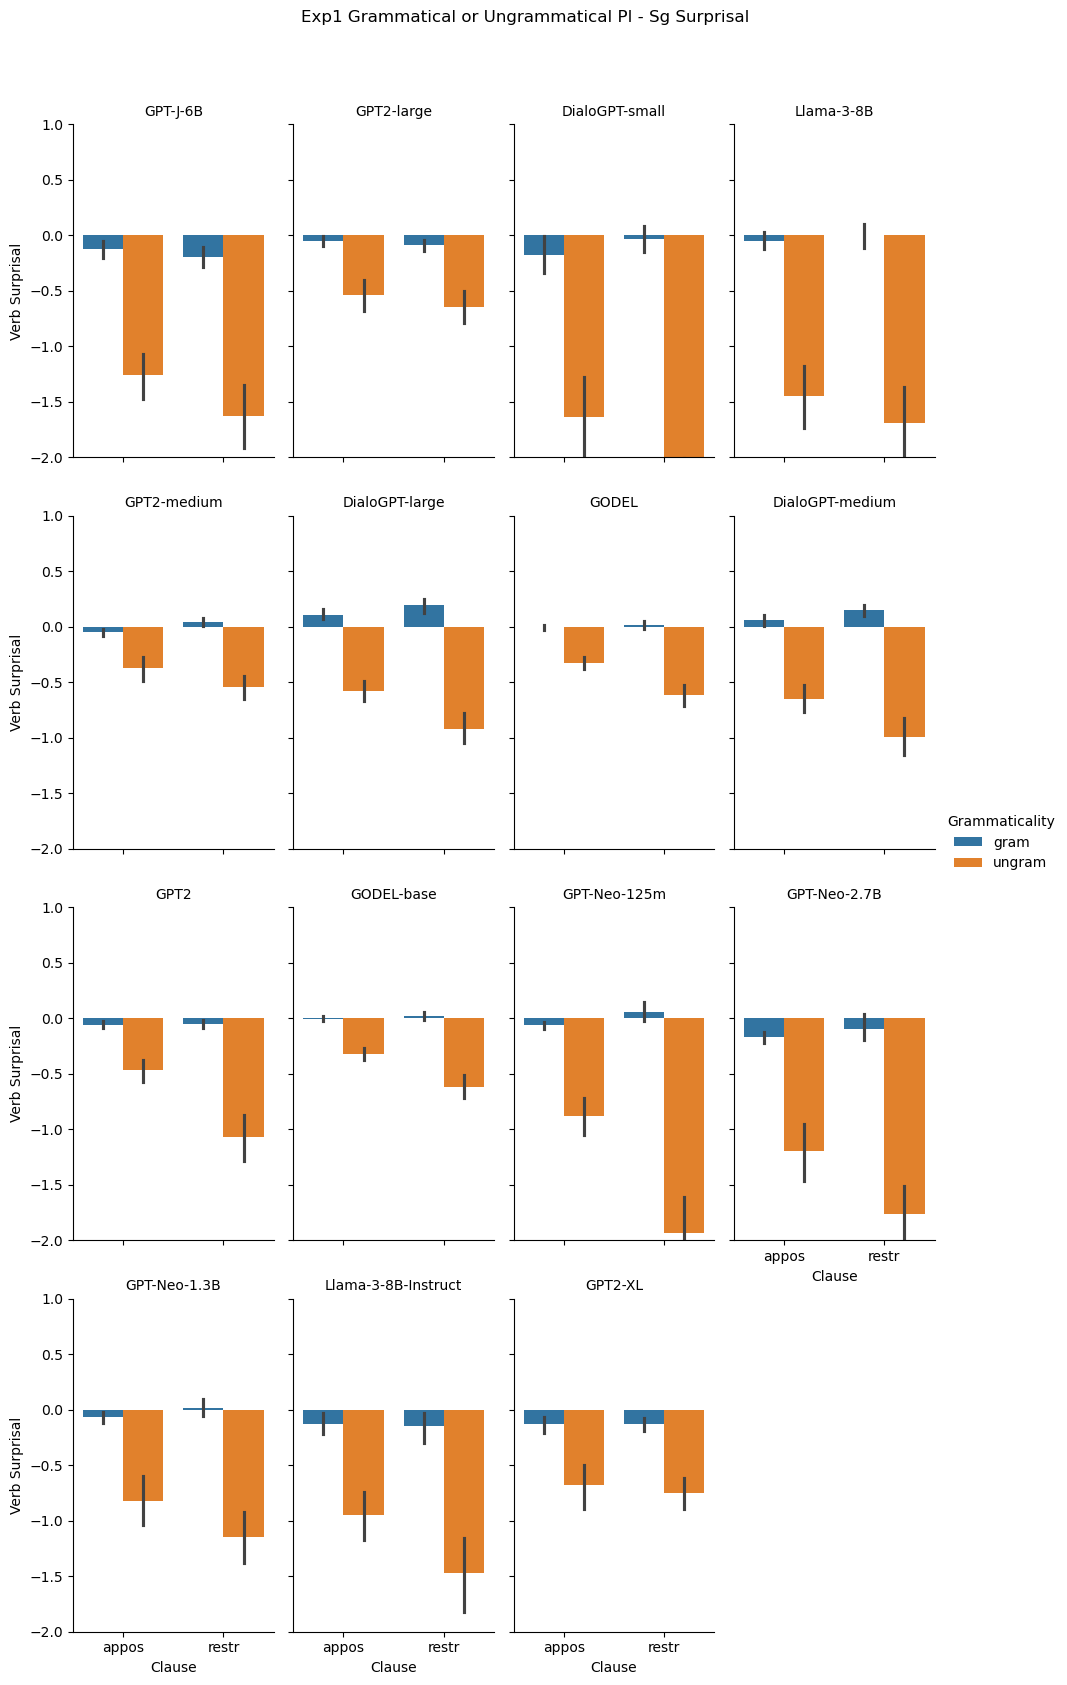

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
g = sns.catplot(
    data=diffs, x="Clause", y="diff", hue='Grammaticality', col="model", 
    kind="bar", height=4, aspect=.6,
    col_wrap=4,
)

g.set_axis_labels("Clause", "Verb Surprisal")
g.set_titles("{col_name}")
plt.suptitle('Exp1 Grammatical or Ungrammatical Pl - Sg Surprisal', y=1.05)
plt.ylim(-2, 1)
g.savefig('exp1_diffs.png')

## Plot exp2 results

In [32]:
# compile results 
import glob 
fnames = list(filter(lambda x: 'exp2_' in x, glob.glob('sub_results/*.tsv')))
print(fnames)

surp_exp2 = None
for fname in fnames:
    data = pd.read_csv(fname, sep='\t')
    if surp_exp2 is None:
        surp_exp2 = data
    else:
        surp_exp2 = pd.concat([surp_exp2, data])

['sub_results/exp2_DialoGPT-large.tsv', 'sub_results/exp2_GODEL.tsv', 'sub_results/exp2_Llama-3-8B-Instruct.tsv', 'sub_results/exp2_GPT2.tsv', 'sub_results/exp2_GPT-J-6B.tsv']


In [33]:
surp_exp2.head(3)

,ItemNo,Clause,Distractor,Grammaticality,Condition,w1,w2,w3,w4,w5,...,w14,w15,w16,w17,w18,w19,w20,sentence,model,surp
0,1,restr,plural,gram,e.restr.plural.gram,The,runners,who,the,driver,...,to,say,hi.,NaN,NaN,NaN,NaN,The runners who the driver sees,DialoGPT-large,14.173013
1,1,restr,singular,gram,e.restr.singular.gram,The,runner,who,the,driver,...,to,say,hi.,NaN,NaN,NaN,NaN,The runner who the driver sees,DialoGPT-large,13.825932
2,1,restr,plural,ungram,e.restr.plural.ungram,The,runners,who,the,driver,...,to,say,hi.,NaN,NaN,NaN,NaN,The runners who the driver see,DialoGPT-large,15.432075


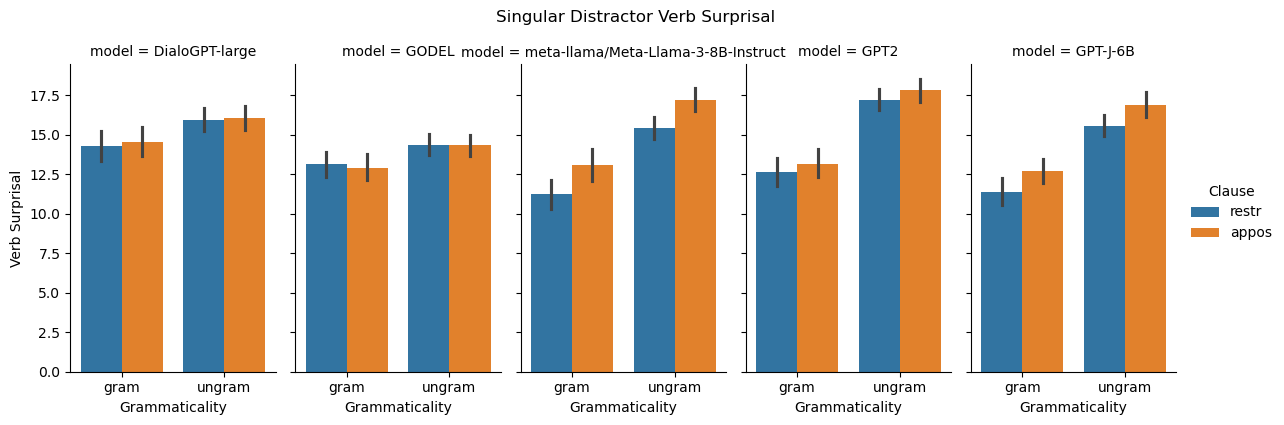

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.catplot(
    data=surp_exp2[surp_exp2['Distractor'] == 'singular'], x="Grammaticality", y="surp", col="model", hue='Clause',
    kind="bar", height=4, aspect=.6,
)

g.set_axis_labels("Grammaticality", "Verb Surprisal")
plt.suptitle('Singular Distractor Verb Surprisal', y=1.05)
g.savefig('exp2_sg_surp.png')

In [ ]:
g = sns.catplot(
    data=surp_exp2[surp_exp2['Distractor'] != 'singular'], x="Grammaticality", y="surp", col="model", hue='Clause',
    kind="bar", height=4, aspect=.6,
)

g.set_axis_labels("Grammaticality", "Verb Surprisal")
plt.suptitle('Plural Distractor Verb Surprisal', y=1.05)
g.savefig('exp2_pl_surp.png')

In [ ]:
g = sns.catplot(
    data=surp_exp2, x="Grammaticality", y="surp", col="model", hue='Clause',
    kind="bar", height=4, aspect=.6,
)

g.set_axis_labels("Grammaticality", "Verb Surprisal")
plt.suptitle('Combined Distractor Verb Surprisal', y=1.05)
g.savefig('exp2_surp.png')

In [35]:
gram_exp2 = surp_exp2[surp_exp2['Grammaticality'] != 'ungram']
pl = gram_exp2[gram_exp2['Distractor'] == 'plural'].reset_index()
sg = gram_exp2[gram_exp2['Distractor'] != 'plural'].reset_index()

pl['diff'] = pl['surp'] - sg['surp']

temp = pl.copy()

ungram_exp2 = surp_exp2[surp_exp2['Grammaticality'] == 'ungram']
pl = ungram_exp2[ungram_exp2['Distractor'] == 'plural'].reset_index()
sg = ungram_exp2[ungram_exp2['Distractor'] != 'plural'].reset_index()

pl['diff'] = pl['surp'] - sg['surp']

diffs = pd.concat([temp, pl])

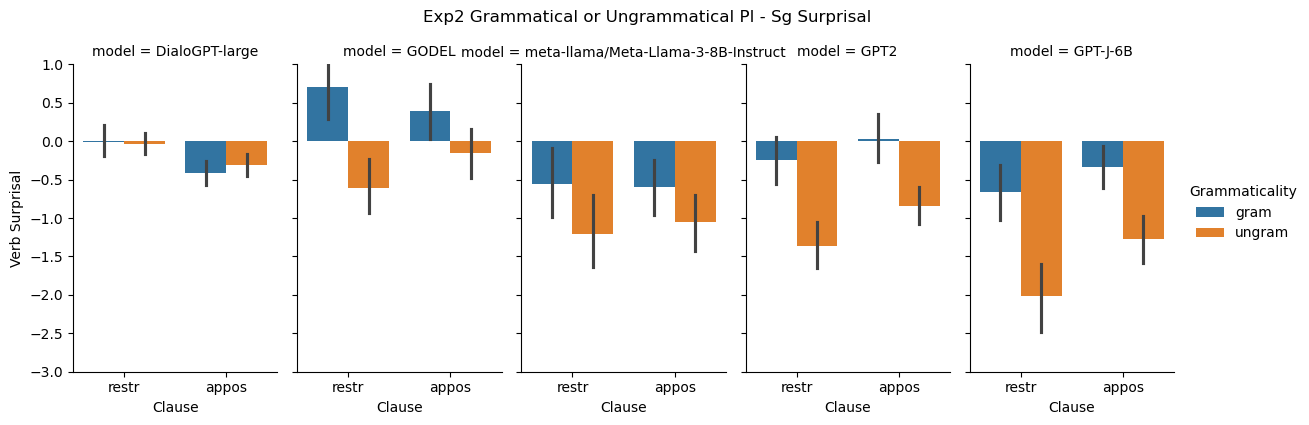

In [36]:
g = sns.catplot(
    data=diffs, x="Clause", y="diff", hue='Grammaticality', col="model", 
    kind="bar", height=4, aspect=.6,
)

g.set_axis_labels("Clause", "Verb Surprisal")
plt.suptitle('Exp2 Grammatical or Ungrammatical Pl - Sg Surprisal', y=1.05)
plt.ylim(-3, 1)
g.savefig('exp2_diffs.png')

## Plot exp3 results

In [27]:
# compile results 
import glob 
fnames = list(filter(lambda x: 'exp3_' in x, glob.glob('sub_results/*.tsv')))
print(fnames)

surp_exp3 = None
for fname in fnames:
    data = pd.read_csv(fname, sep='\t')
    if surp_exp3 is None:
        surp_exp3 = data
    else:
        surp_exp3 = pd.concat([surp_exp3, data])

['sub_results/exp3_GODEL-base.tsv', 'sub_results/exp3_GPT-Neo-2.7B.tsv', 'sub_results/exp3_Llama-3-8B-Instruct.tsv', 'sub_results/exp3_GPT-Neo-1.3B.tsv', 'sub_results/exp3_GPT2-XL.tsv', 'sub_results/exp3_Llama-3-8B.tsv', 'sub_results/exp3_GPT2-large.tsv', 'sub_results/exp3_DialoGPT-medium.tsv', 'sub_results/exp3_GPT2.tsv', 'sub_results/exp3_DialoGPT-small.tsv', 'sub_results/exp3_GODEL.tsv', 'sub_results/exp3_GPT-Neo-125m.tsv', 'sub_results/exp3_DialoGPT-large.tsv', 'sub_results/exp3_GPT2-medium.tsv', 'sub_results/exp3_GPT-J-6B.tsv']


In [38]:
surp_exp3.head(3)

,ItemNo,Clause,Distractor,Grammaticality,Condition,w1,w2,w3,w4,w5,...,w11,w12,w13,w14,w15,w16,w17,sentence,model,surp
0,1,restr,plural,gram,e.restr.plural.gram,Mike,chased,the,runners,who,...,commute,every,morning.,NaN,NaN,NaN,NaN,Mike chased the runners who the driver sees,GPT2,15.580732
1,1,restr,singular,gram,e.restr.singular.gram,Mike,chased,the,runner,who,...,commute,every,morning.,NaN,NaN,NaN,NaN,Mike chased the runner who the driver sees,GPT2,15.009935
2,1,restr,plural,ungram,e.restr.plural.ungram,Mike,chased,the,runners,who,...,commute,every,morning.,NaN,NaN,NaN,NaN,Mike chased the runners who the driver see,GPT2,16.913248


In [39]:
gram_exp3 = surp_exp3[surp_exp3['Grammaticality'] != 'ungram']
pl = gram_exp3[gram_exp3['Distractor'] == 'plural'].reset_index()
sg = gram_exp3[gram_exp3['Distractor'] != 'plural'].reset_index()

pl['diff'] = pl['surp'] - sg['surp']

temp = pl.copy()

ungram_exp3 = surp_exp3[surp_exp3['Grammaticality'] == 'ungram']
pl = ungram_exp3[ungram_exp3['Distractor'] == 'plural'].reset_index()
sg = ungram_exp3[ungram_exp3['Distractor'] != 'plural'].reset_index()

pl['diff'] = pl['surp'] - sg['surp']

diffs = pd.concat([temp, pl])

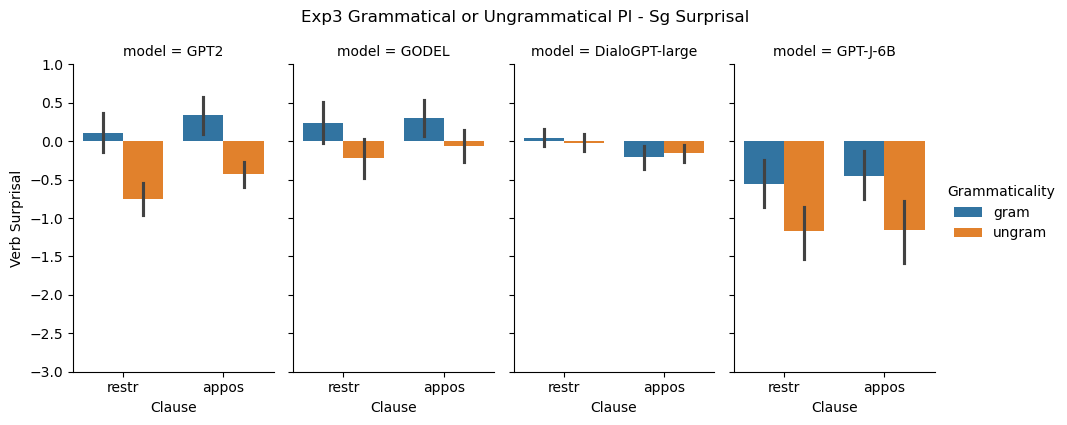

In [40]:
g = sns.catplot(
    data=diffs, x="Clause", y="diff", hue='Grammaticality', col="model", 
    kind="bar", height=4, aspect=.6,
)

g.set_axis_labels("Clause", "Verb Surprisal")
plt.suptitle('Exp3 Grammatical or Ungrammatical Pl - Sg Surprisal', y=1.05)
plt.ylim(-3, 1)
g.savefig('exp3_diffs.png')

## Compile

In [62]:
fnames = list(filter(lambda x: 'exp3_' in x, glob.glob('sub_results/*.tsv')))
# Clean up clarity in names 
for fname in fnames:
    data = pd.read_csv(fname, sep='\t')
    print(data['model'].unique())
    if data['model'].tolist()[0] == 'GPT2':
        data['model'] = 'GPT2-small'
        data.to_csv(fname, sep='\t', index=False)
    if data['model'].tolist()[0] == 'meta-llama/Meta-Llama-3-8B-Instruct':
        data['model'] = 'Llama-3-8B-Instruct'
        data.to_csv(fname, sep='\t', index=False)
    if data['model'].tolist()[0] == "Mistral-7B-Instrcut-v0.3":
        data['model'] = "Mistral-7B-Instruct-v0.3"
        data.to_csv(fname, sep='\t', index=False)
    if 'modelname' not in data.columns:
        if data['model'].tolist()[0] == 'GPT-J-6B':
            data['modelname'] = "EleutherAI/gpt-j-6b"
        if data['model'].tolist()[0] == 'Llama-3-8B': 
            data['modelname'] = "meta-llama/Meta-Llama-3-8B"
        if data['model'].tolist()[0] == 'Llama-3-8B-Instruct':
            data['modelname'] = "meta-llama/Meta-Llama-3-8B-Instruct"
        if data['model'].tolist()[0] == 'DialoGPT-large':
            data['modelname'] = "microsoft/DialoGPT-large"
        if data['model'].tolist()[0] == 'DialoGPT-small':
            data['modelname'] = "microsoft/DialoGPT-small"
        if data['model'].tolist()[0] == 'GODEL':
            data['modelname'] = "microsoft/GODEL-v1_1-large-seq2seq"
            data['model'] = 'GODEL-large'
        if data['model'].tolist()[0] == 'GODEL-base':
            data['modelname'] = "microsoft/GODEL-v1_1-base-seq2seq"
        data.to_csv(fname, sep='\t', index=False)

['GODEL-base']
['GPT-Neo-2.7B']
['Llama-2-7B']
['Llama-3-8B-Instruct']
['GPT-Neo-1.3B']
['GPT2-XL']
['Mistral-7B-Instruct-v0.1']
['Llama-3.1-8B-Instruct']
['Mistral-7B-Instruct-v0.2']
['Mistral-7B-Instruct-v0.3']
['Llama-3-8B']
['GPT2-large']
['DialoGPT-medium']
['Llama-3.1-8B']
['Llama-2-13B']
['Llama-2-7B-Chat']
['Mistral-7B-v0.1']
['Llama-2-13B-Chat']
['Mistral-7B-v0.3']
['GPT2-small']
['DialoGPT-small']
['GODEL-large']
['GPT-Neo-125m']
['DialoGPT-large']
['GPT2-medium']
['GPT-J-6B']


In [63]:
for model_prefix in ['exp1_', 'exp2_', 'exp3_']:
    fnames = list(filter(lambda x: model_prefix in x, glob.glob('sub_results/*.tsv')))
    exp = None
    outname = f"combined_{model_prefix}results.tsv"
    for fname in fnames:
        data = pd.read_csv(fname, sep='\t')
        if exp is None:
            exp = data
        else:
            exp = pd.concat([exp, data])
    #print(data['model'].unique())
    exp['exp'] = model_prefix.replace('_', '')
    exp.to_csv(outname, index=False, sep='\t')


In [64]:
# generate differences 
all_diffs = None
for exp_prefix in ['exp1_', 'exp2_', 'exp3_']:
    data = pd.read_csv(f'combined_{exp_prefix}results.tsv', sep='\t')
    select_cols = ['exp', 'ItemNo', 'Clause', 'Distractor', 
                 'Grammaticality', 'model', 'surp']
    index_cols =  ['exp', 'ItemNo', 'Clause', 
                 'Grammaticality', 'model']
    
    data = data[select_cols]
    data = data.pivot_table(index=index_cols, columns='Distractor', values='surp').reset_index()
    diffs = data.groupby(['exp', 'ItemNo', 'Grammaticality', 'Clause', 'model']).apply(lambda row: row['plural'] - row['singular']).reset_index()
    diffs.drop('level_5', axis=1, inplace=True)
    diffs = diffs.rename(columns={0: 'pl-sg'})
    if all_diffs is None:
        all_diffs = diffs
    else:
        all_diffs = pd.concat([all_diffs, diffs])
    #diffs.to_csv(f'{exp_prefix}diffs.tsv', sep='\t', index=False)
all_diffs.to_csv('experiment_differences.tsv', sep='\t', index=False)

### Get mean differences

In [4]:
import random
import numpy as np
from scipy.stats import sem
from sklearn.utils import resample
# Modified from https://www.tjansson.dk/2023/12/enhancing-pandas-groupby-with-bootstrapped-confidence-intervals/
def calc_mean_count_ci(_df, groupby_cols=None, stat_col=None, n_bootstrap=1000, save_to_file=False):
    """
    Calculate mean, count, and confidence intervals using bootstrapping.
 
    Parameters:
    - _df (DataFrame): Input DataFrame containing the data.
    - groupby_cols (list, optional): List of columns to group the data by. Default is None.
    - stat_col (str, optional): Column name for which to calculate mean, count, and confidence intervals.
    - n_bootstrap (int, optional): Number of bootstrap samples to generate. Default is 1000.
    - save_to_file (bool, optional): If True, save the results to a CSV file. Default is False.
 
    Returns:
    - DataFrame: A DataFrame containing mean, count, and confidence interval information
                 for the specified groupby columns and statistical column.
 
    Example:
    >>> result_df = calc_mean_count_ci(df, ['A', 'B'], 'score')
 
    Notes:
    - The function utilizes bootstrapping to estimate the confidence interval for the mean.
    - The result DataFrame includes columns for count, mean, and confidence intervals.
    - If save_to_file is True, the result is saved to a CSV file with a filename based on the current date,
      groupby columns, statistical column, and the term 'mean_count_ci'.
    """
 
    # Define a function to calculate confidence interval using bootstrapping
    def calculate_ci_bootstrap(data):
        means = []
        for _ in range(n_bootstrap):
            sample = resample(data)  # Bootstrap resampling
            mean = np.mean(sample)  # Calculate mean of the resampled data
            means.append(mean)
 
        # Calculate the mean of the whole dataset and the confidence interval 
        # from the distribution of the sample means
        data_mean = np.mean(data)
        confidence_interval = np.percentile(means, [2.5, 97.5])
 
        return pd.DataFrame({
            'count': [len(data)],
            'mean_ci_lower': [confidence_interval[0]],
            'mean': [data_mean],
            'mean_ci_upper': [confidence_interval[1]],
        }).round(4)
 
    # Group by columns A and B, apply the calculate_ci_bootstrap function to 
    # the 'score' column, and merge the results
    result = (
        _df.groupby(groupby_cols)[stat_col]
        .apply(calculate_ci_bootstrap)
        .reset_index()
        .drop(columns=[f"level_{len(groupby_cols)}"])
    )
 
    # Save the data to a file with the current date, columns and basic info the dataframe
    if save_to_file:
        name = f'{datetime.now().date().isoformat()}-{"-".join(groupby_cols)}-{stat_col}-mean_count_ci.csv'
        result.to_csv(name, index=False)
        print(f'Saved data to {name}')
 
    return result

In [5]:
diffs = pd.read_csv('experiment_differences.tsv', sep='\t')
diffs.drop('ItemNo', axis=1, inplace=True)
mean_diffs = calc_mean_count_ci(diffs, ['exp', 'model', 'Grammaticality', 'Clause'], 'pl-sg')
mean_diffs.head()

,exp,model,Grammaticality,Clause,count,mean_ci_lower,mean,mean_ci_upper
0,exp1,DialoGPT-large,gram,appos,48,0.0688,0.1107,0.1547
1,exp1,DialoGPT-large,gram,restr,48,0.1295,0.1918,0.2549
2,exp1,DialoGPT-large,ungram,appos,48,-0.6671,-0.5795,-0.4909
3,exp1,DialoGPT-large,ungram,restr,48,-1.0681,-0.9159,-0.7881
4,exp1,DialoGPT-medium,gram,appos,48,0.0139,0.0576,0.1034


In [67]:
print(diffs['model'].unique())
print(len(diffs['model'].unique()))

['DialoGPT-large' 'DialoGPT-medium' 'DialoGPT-small' 'GODEL-base'
 'GODEL-large' 'GPT-J-6B' 'GPT-Neo-1.3B' 'GPT-Neo-125m' 'GPT-Neo-2.7B'
 'GPT2-XL' 'GPT2-large' 'GPT2-medium' 'GPT2-small' 'Llama-2-13B'
 'Llama-2-13B-Chat' 'Llama-2-7B' 'Llama-2-7B-Chat' 'Llama-3-8B'
 'Llama-3-8B-Instruct' 'Llama-3.1-8B' 'Llama-3.1-8B-Instruct'
 'Mistral-7B-Instruct-v0.1' 'Mistral-7B-Instruct-v0.2'
 'Mistral-7B-Instruct-v0.3' 'Mistral-7B-v0.1' 'Mistral-7B-v0.3']
26


In [68]:
model2details = {"DialoGPT-large": 
                     {"Training Type": "Dialogue", 
                      "Model Size": "762M"}, 
                "DialoGPT-medium": 
                     {"Training Type": "Dialogue", 
                      "Model Size": "345M"}, 
                "DialoGPT-small": 
                     {"Training Type": "Dialogue", 
                      "Model Size": "117M"}, 
                "GODEL-base":
                     {"Training Type": "Dialogue", 
                      "Model Size": "220M"}, 
                "GODEL-large":
                     {"Training Type": "Dialogue", 
                      "Model Size": "770M"}, 
                "GPT-J-6B":
                     {"Training Type": "Plain", 
                      "Model Size": "6B"}, 
                "GPT-Neo-1.3B":
                     {"Training Type": "Plain", 
                      "Model Size": "1.3B"}, 
                "GPT-Neo-125m":
                     {"Training Type": "Plain", 
                      "Model Size": "125M"}, 
                "GPT-Neo-2.7B":
                     {"Training Type": "Plain", 
                      "Model Size": "2.7B"}, 
                "GPT2-XL":
                     {"Training Type": "Plain", 
                      "Model Size": "1.5B"}, 
                "GPT2-large":
                     {"Training Type": "Plain", 
                      "Model Size": "774M"}, 
                "GPT2-medium":
                     {"Training Type": "Plain", 
                      "Model Size": "355M"}, 
                "GPT2-small":
                     {"Training Type": "Plain", 
                      "Model Size": "124M"}, 
                "Llama-3-8B":
                     {"Training Type": "Plain", 
                      "Model Size": "8B"}, 
                "Llama-3-8B-Instruct":
                     {"Training Type": "Instruct", 
                      "Model Size": "8B"}, 
                "Llama-2-7B":
                     {"Training Type": "Plain", 
                      "Model Size": "7B"}, 
                "Llama-2-7B-Chat":
                     {"Training Type": "Instruct", 
                      "Model Size": "7B"}, 
                "Llama-2-13B":
                     {"Training Type": "Plain", 
                      "Model Size": "13B"}, 
                "Llama-2-13B-Chat":
                     {"Training Type": "Instruct", 
                      "Model Size": "13B"}, 
                "Mistral-7B-v0.3":
                     {"Training Type": "Plain", 
                      "Model Size": "7B"}, 
                "Mistral-7B-Instruct-v0.3":
                     {"Training Type": "Instruct", 
                      "Model Size": "7B"}, 
                "Mistral-7B-v0.1":
                     {"Training Type": "Plain", 
                      "Model Size": "7B"}, 
                "Mistral-7B-Instruct-v0.1":
                     {"Training Type": "Instruct", 
                      "Model Size": "7B"}, 
                "Mistral-7B-v0.2":
                     {"Training Type": "Plain", 
                      "Model Size": "7B"}, 
                "Mistral-7B-Instruct-v0.2":
                     {"Training Type": "Instruct", 
                      "Model Size": "7B"}, 
                "Llama-3.1-8B":
                     {"Training Type": "Plain", 
                      "Model Size": "8B"}, 
                "Llama-3.1-8B-Instruct":
                     {"Training Type": "Instruct", 
                      "Model Size": "8B"}, 
                "Llama-3.1-70B":
                     {"Training Type": "Plain", 
                      "Model Size": "70B"}, 
                "Llama-3.1-70B-Instruct":
                     {"Training Type": "Instruct", 
                      "Model Size": "70B"}, 
                }

### Get table of difference by-clause from zero 

In [69]:
# Check for 0, mean direction, and add model details 
by_clause = mean_diffs.copy()
containsZero = []
direction = []
infos = {}
for info in model2details['GPT2-small']:
    infos[info] = []
    
for _, row in by_clause.iterrows():
    lower = row['mean_ci_lower']
    upper = row['mean_ci_upper']
    if row['mean'] > 0:
        direction.append('positive')
    else:
        direction.append('negative')
    if lower < 0 and upper < 0:
        containsZero.append('no')
    elif lower > 0 and upper > 0:
        containsZero.append('no')
    else:
        containsZero.append('yes')
    info = model2details[row['model']]
    for k, v in info.items():
        infos[k].append(v)
by_clause['ContainsZero'] = containsZero
by_clause['direction'] = direction
for info, value in infos.items():
    by_clause[info] = value
by_clause.to_csv('by_clause_difference_table.tsv', index=False, sep='\t')

### Get table of clause overlap

In [70]:
clause_diff = mean_diffs.copy()
RRC = clause_diff[clause_diff['Clause'] == 'restr'].reset_index()
ARC = clause_diff[clause_diff["Clause"] == 'appos'].reset_index()

models = RRC['model'].tolist()

RRC_lowers = RRC['mean_ci_lower'].tolist()
RRC_uppers = RRC['mean_ci_upper'].tolist()
RRC_means = RRC['mean'].tolist()

ARC_lowers = ARC['mean_ci_lower'].tolist()
ARC_uppers = ARC['mean_ci_upper'].tolist()
ARC_means = ARC['mean'].tolist()

infos = {}
for info in model2details['GPT2-small']:
    infos[info] = []
    
direction = []
significant = []
RRC_direction = []
ARC_direction = []
def getOverlap(a, b):
    return max(0, min(a[1], b[1]) - max(a[0], b[0]))
    
for idx in range(len(RRC_means)):
    model = models[idx] 
    
    RRC_mean = RRC_means[idx]
    RRC_upper = RRC_uppers[idx]
    RRC_lower = RRC_lowers[idx]

    ARC_mean = ARC_means[idx]
    ARC_upper = ARC_uppers[idx]
    ARC_lower = ARC_lowers[idx]

    if getOverlap((RRC_lower, RRC_upper), (ARC_lower, ARC_upper)):
        significant.append('yes')
    else:
        significant.append('no')

    if RRC_mean > ARC_mean:
        direction.append('greater')
    else:
        direction.append('less')
 
    if RRC_mean > 0:
        RRC_direction.append('positive')
    else:
        RRC_direction.append('negative')

    if ARC_mean > 0:
        ARC_direction.append('positive')
    else:
        ARC_direction.append('negative')
        
    info = model2details[model]
    for k, v in info.items():
        infos[k].append(v)
        
for info, value in infos.items():
    RRC[info] = value
RRC.drop(['Clause', "count", "mean", "mean_ci_upper", "mean_ci_lower", "index"], axis=1, inplace=True)
RRC['RRC Direction'] = RRC_direction
RRC['ARC Direction'] = ARC_direction
RRC['RRC Compared to ARC'] = direction
RRC['overlaps'] = significant
RRC.to_csv('clause_comparison_table.tsv', index=False, sep='\t')

### Look for ungrammatical good

In [71]:
by_clause.head()

,exp,model,Grammaticality,Clause,count,mean_ci_lower,mean,mean_ci_upper,ContainsZero,direction,Training Type,Model Size
0,exp1,DialoGPT-large,gram,appos,48,0.0676,0.1107,0.1543,no,positive,Dialogue,762M
1,exp1,DialoGPT-large,gram,restr,48,0.1298,0.1918,0.2536,no,positive,Dialogue,762M
2,exp1,DialoGPT-large,ungram,appos,48,-0.6682,-0.5795,-0.4925,no,negative,Dialogue,762M
3,exp1,DialoGPT-large,ungram,restr,48,-1.0517,-0.9159,-0.7885,no,negative,Dialogue,762M
4,exp1,DialoGPT-medium,gram,appos,48,0.0134,0.0576,0.1006,no,positive,Dialogue,345M


In [72]:
subset = by_clause[by_clause['exp'] == 'exp1']
subset = subset[subset['Grammaticality'] == 'gram']
subset_appos = subset[subset['Clause'] == 'appos']
subset_restr = subset[subset['Clause'] == 'restr']
models_appos = set(subset_appos[subset_appos['ContainsZero'] == 'yes']['model'])
models_restr = set(subset_restr[subset_restr['ContainsZero'] == 'yes']['model'])
keep = []
for model in models_appos:
    if model in models_restr:
        keep.append(model)

In [74]:
for model in keep:
    print(model)

GODEL-large
Llama-3-8B
Mistral-7B-v0.3
Llama-3.1-8B
GODEL-base
Llama-2-13B


In [75]:
subset = RRC[RRC['exp'] == 'exp1']
subset = subset[subset['Grammaticality'] == 'ungram']
subset = subset[subset['overlaps'] == 'no']
ungram_models_exp1 = set(subset['model'].unique())

In [76]:
for model in ungram_models_exp1:
    print(model)

DialoGPT-large
GODEL-large
GPT2-small
Mistral-7B-v0.3
GPT-Neo-2.7B
GODEL-base
DialoGPT-medium
GPT-Neo-125m


In [80]:
RRC[RRC['model'] == 'Llama-3.1-8B']


,exp,model,Grammaticality,Training Type,Model Size,RRC Direction,ARC Direction,RRC Compared to ARC,overlaps
38,exp1,Llama-3.1-8B,gram,Plain,8B,negative,negative,greater,yes
39,exp1,Llama-3.1-8B,ungram,Plain,8B,negative,negative,less,yes
90,exp2,Llama-3.1-8B,gram,Plain,8B,negative,negative,less,yes
91,exp2,Llama-3.1-8B,ungram,Plain,8B,negative,negative,less,yes
142,exp3,Llama-3.1-8B,gram,Plain,8B,negative,negative,greater,yes
143,exp3,Llama-3.1-8B,ungram,Plain,8B,negative,negative,greater,yes


In [77]:
subset = RRC[RRC['exp'] == 'exp1']
subset = subset[subset['Grammaticality'] == 'gram']
subset = subset[subset['overlaps'] == 'yes']
gram_models_exp1 = set(subset['model'].unique())

In [79]:
for model in ungram_models_exp1:
    if model in gram_models_exp1:
        print(model)

DialoGPT-large
GODEL-large
GPT2-small
Mistral-7B-v0.3
GPT-Neo-2.7B
GODEL-base
DialoGPT-medium


In [60]:
subset = RRC[RRC['exp'] == 'exp2']
subset = subset[subset['Grammaticality'] == 'ungram']
subset = subset[subset['overlaps'] == 'yes']
models_exp2 = set(subset['model'].unique())

In [61]:
for model in models_exp2:
    if model in ungram_models_exp1:
        print(model)

DialoGPT-large
GODEL-large
GPT-Neo-125m
GPT2-small
GPT-Neo-2.7B
GODEL-base
DialoGPT-medium


### Plots

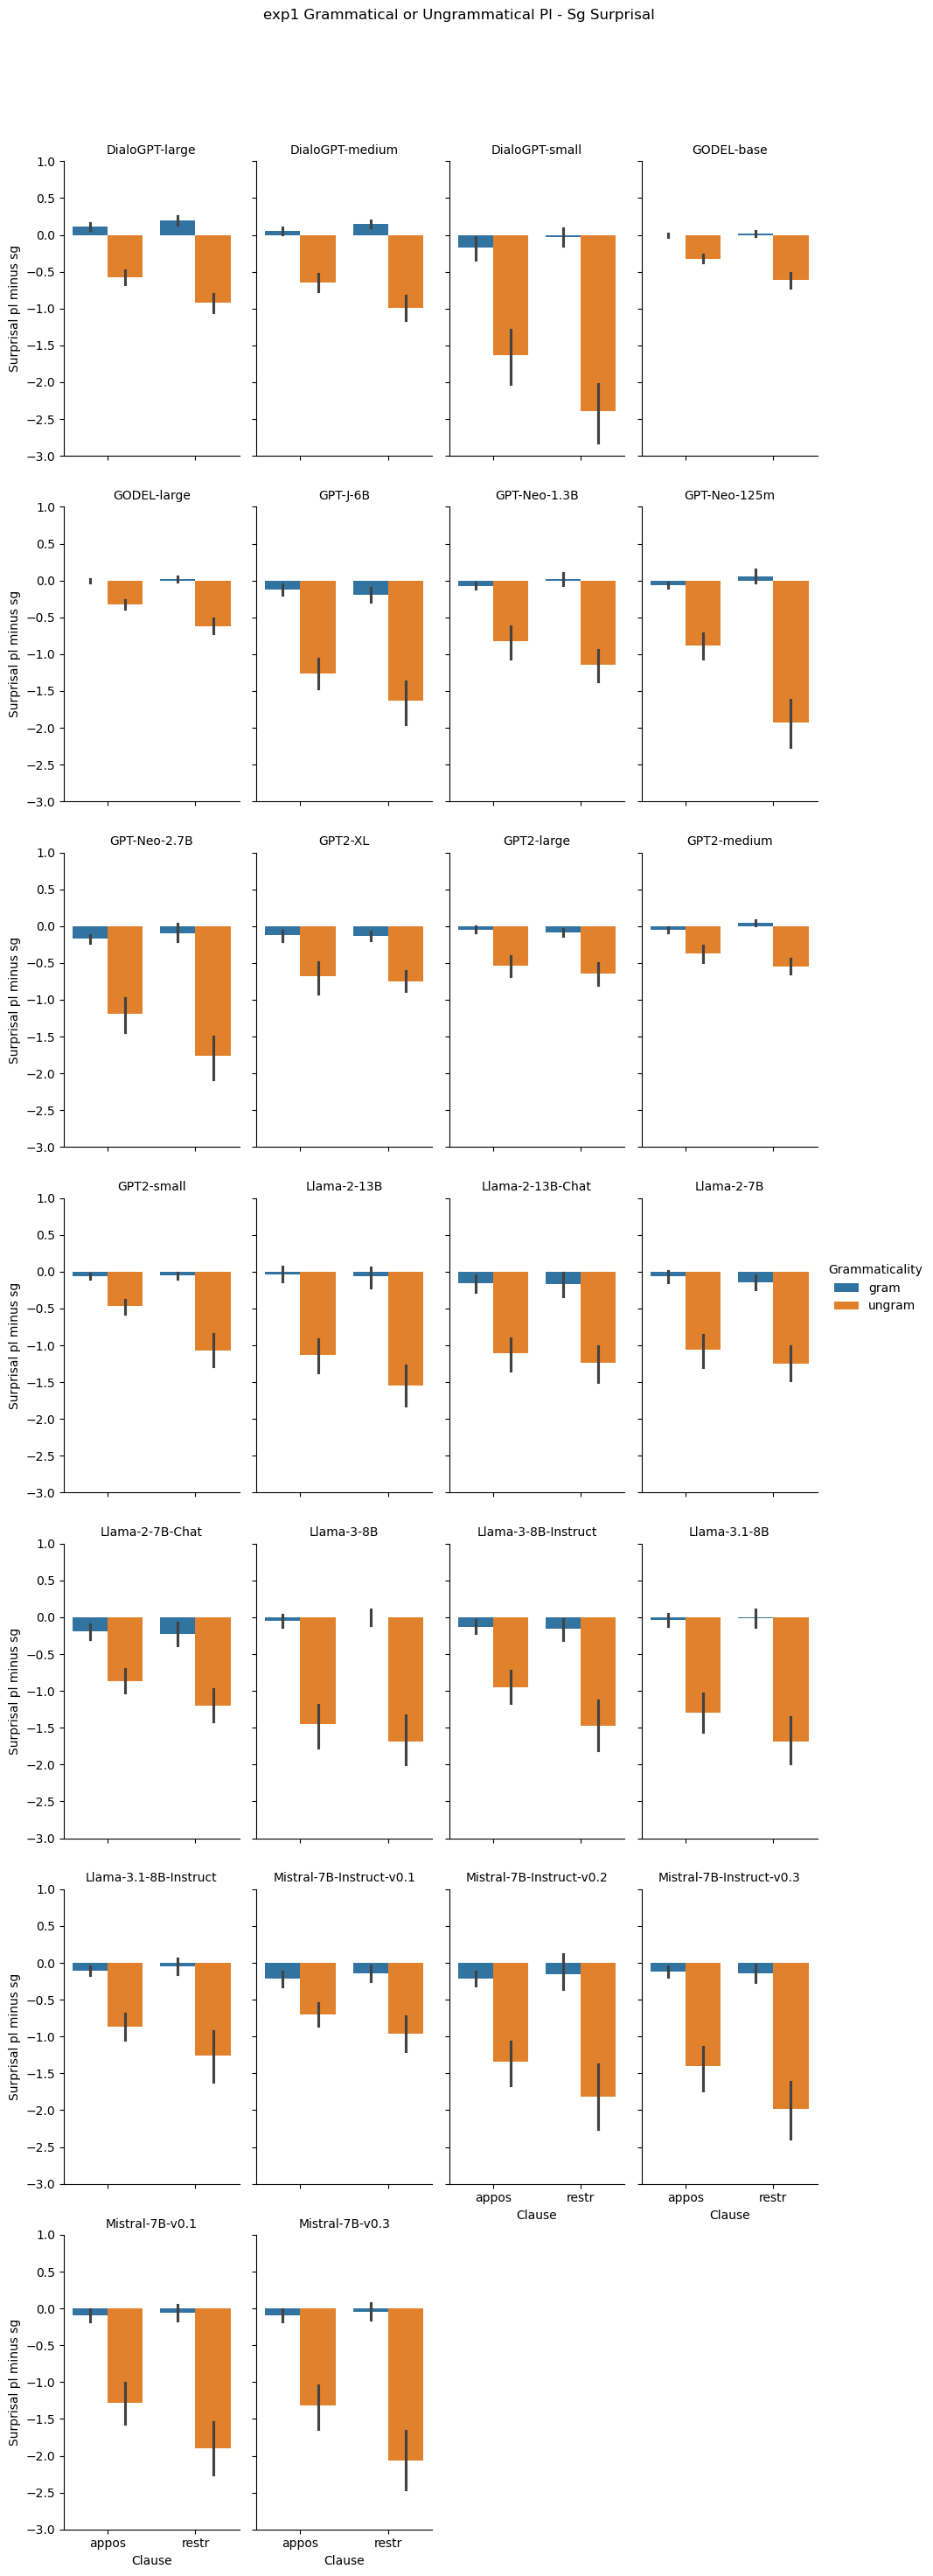

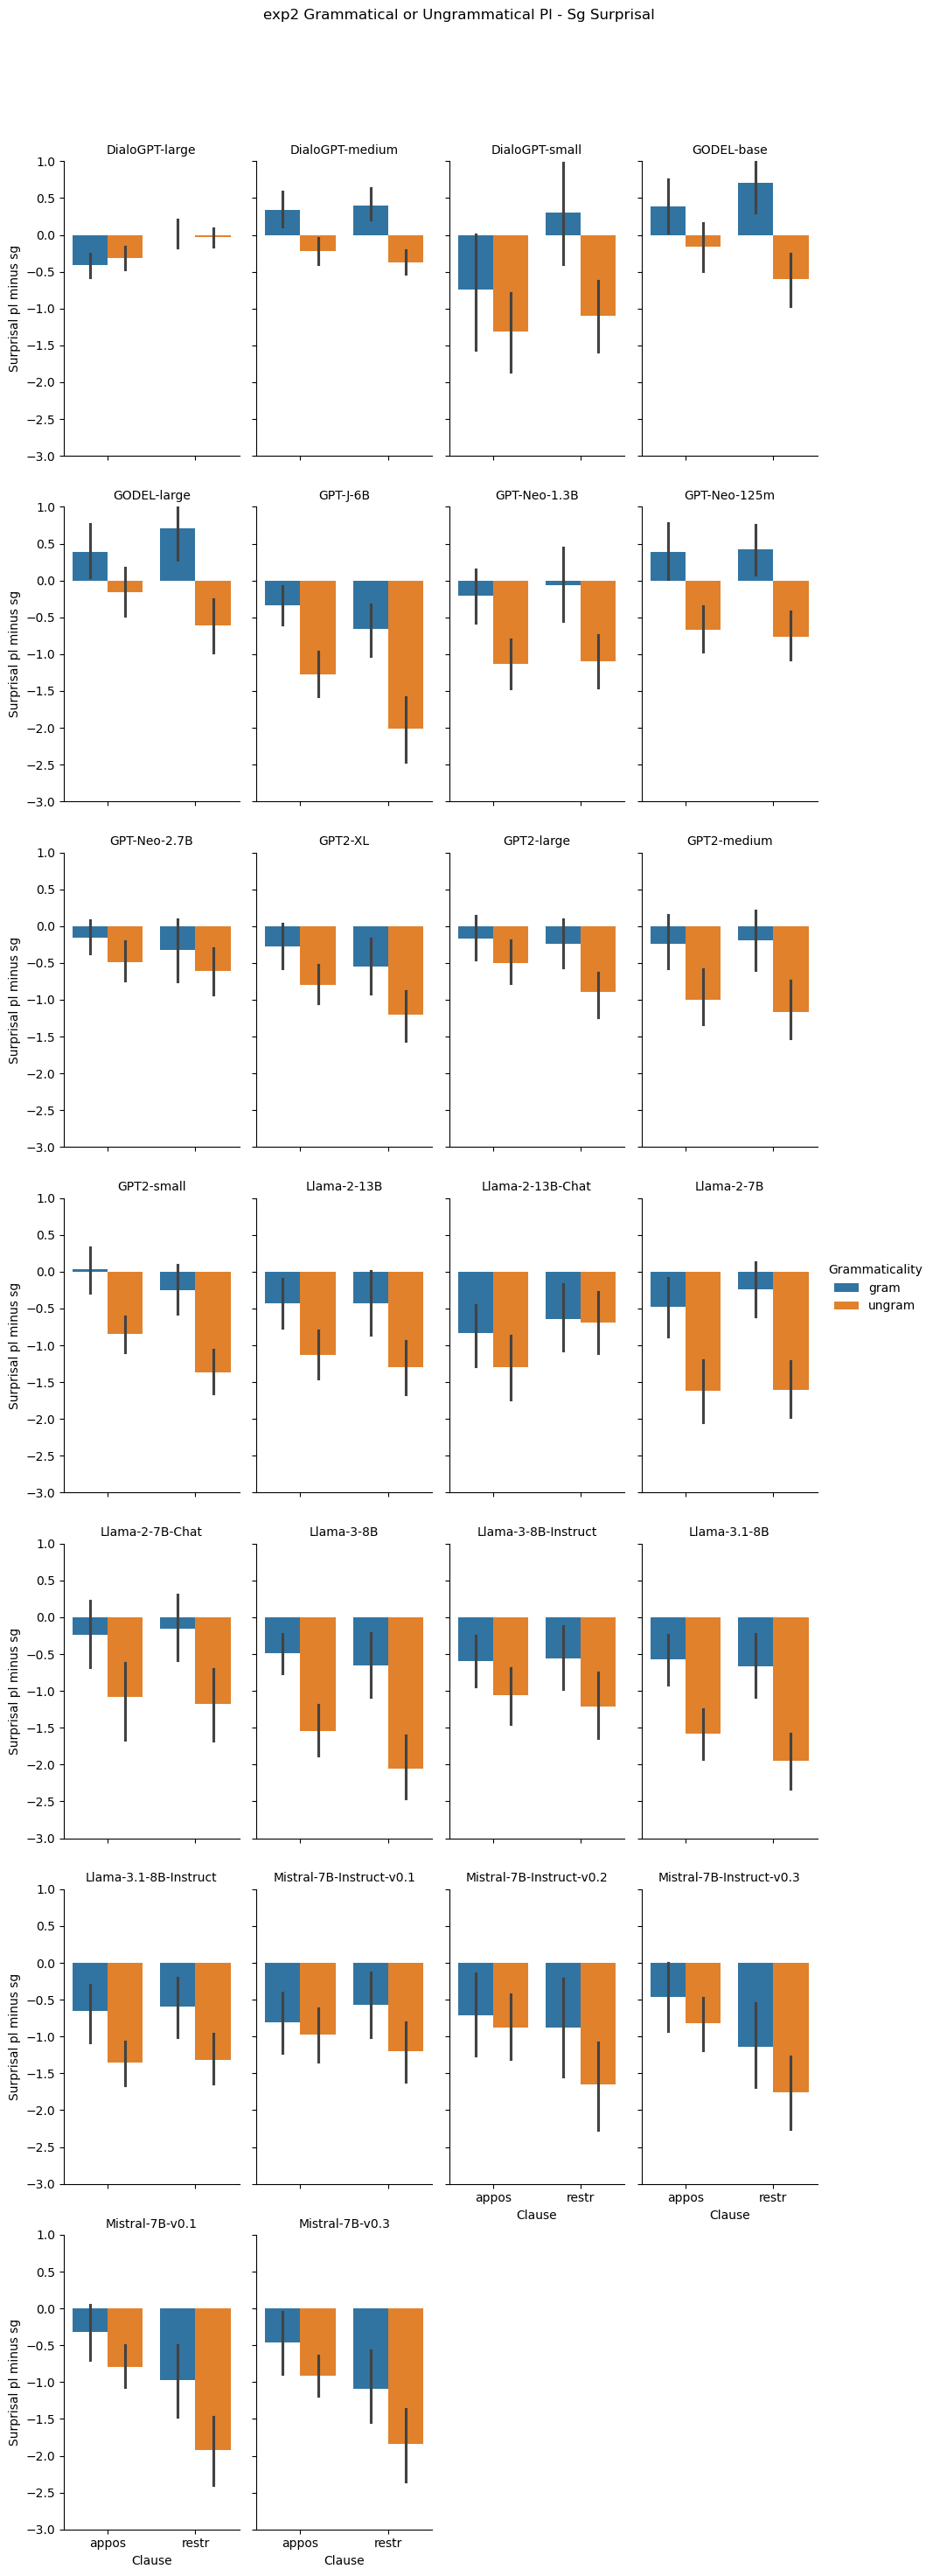

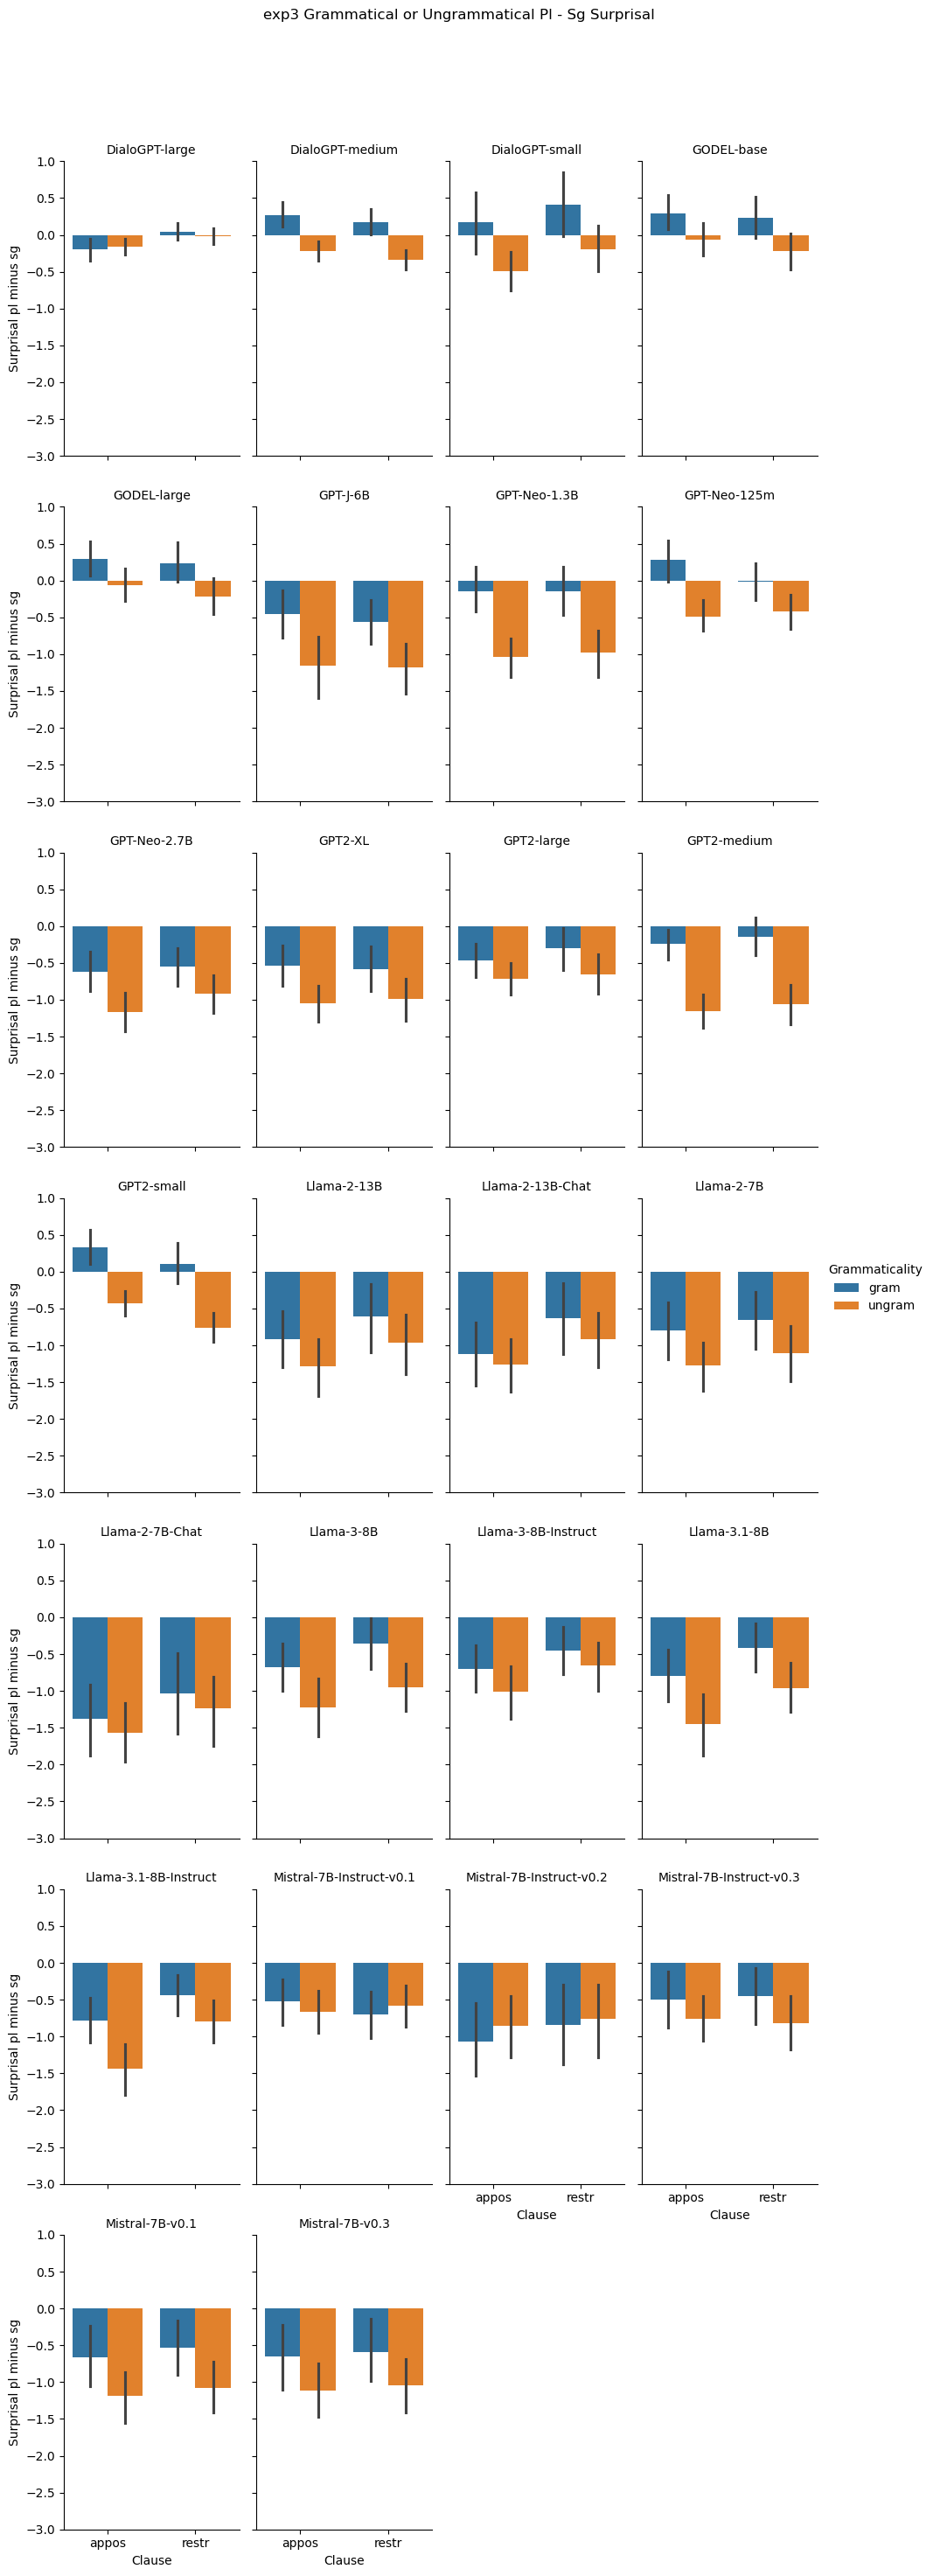

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt

for exp in ['exp1', 'exp2', 'exp3']:
    g = sns.catplot(
        data=diffs[diffs['exp'] == exp], x="Clause", y="pl-sg", hue='Grammaticality', col="model", 
        kind="bar", height=4, aspect=.6,
        col_wrap=4,
    )
    
    g.set_axis_labels("Clause", "Surprisal pl minus sg")
    g.set_titles("{col_name}")
    plt.suptitle(f'{exp} Grammatical or Ungrammatical Pl - Sg Surprisal', y=1.05)
    plt.ylim(-3, 1)
    g.savefig(f'{exp}_diffs.png')